In [ ]:
from google.colab import drive
from glob import glob
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, AveragePooling2D, Dense, Activation, DepthwiseConv2D,Dropout
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import class_weight
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
glob('/content/gdrive/MyDrive/ROIJPG_2/*G*/*')

['/content/gdrive/MyDrive/ROIJPG_2/G1/G1',
 '/content/gdrive/MyDrive/ROIJPG_2/G2/G2',
 '/content/gdrive/MyDrive/ROIJPG_2/G3/G3']

In [ ]:
from glob import glob

# Paths to the dataset
Grade_1 = glob('/content/gdrive/MyDrive/ROIJPG_2/G1/G1*/*')
Grade_2 = glob('/content/gdrive/MyDrive/ROIJPG_2/G2/G2*/*')
Grade_3 = glob('/content/gdrive/MyDrive/ROIJPG_2/G3/G3*/*')

In [ ]:
print ("Grade_1: ",len(Grade_1))
print ("Grade_2: ",len(Grade_2))
print ("Grade_3: ",len(Grade_3))

Grade_1:  446
Grade_2:  376
Grade_3:  446


In [ ]:
import random

def apply_horizontal_flip(image):
    flipped_image = cv2.flip(image, 1)  # Flip horizontally
    return flipped_image

def apply_vertical_flip(image):
    flipped_image = cv2.flip(image, 0)  # Flip vertically
    return flipped_image

def apply_brightness_adjustment(image):
    # Randomly adjust brightness by scaling pixel values
    alpha = 1.0 + random.uniform(-0.2, 0.2)  # Scale factor
    adjusted_image = cv2.multiply(image, np.array([alpha]))  # Multiply pixel values by scale factor
    return adjusted_image


In [ ]:
def read_and_preprocess_images(file_paths, num_images_per_file, resize_dim=(224, 224), augmentation=False):
    images = []

    for file_path in file_paths:
        if os.path.isfile(file_path) and file_path.lower().endswith(('.jpg', '.jpeg', '.png')):
            img = cv2.imread(file_path, cv2.IMREAD_COLOR)

            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

                if augmentation:
                    # Apply horizontal and vertical flipping augmentation
                    flipped_horizontal_img = apply_horizontal_flip(img)
                    flipped_vertical_img = apply_vertical_flip(img)
                    brightness_adjusted_img = apply_brightness_adjustment(img)

                    # Resize augmented images
                    resized_horizontal_img = cv2.resize(flipped_horizontal_img, resize_dim)
                    resized_vertical_img = cv2.resize(flipped_vertical_img, resize_dim)
                    resized_brightness_adjusted_img = cv2.resize(brightness_adjusted_img, resize_dim)

                    # Append augmented images to the list
                    images.extend([resized_horizontal_img, resized_vertical_img, resized_brightness_adjusted_img])

                # Append original image as well
                resized_img = cv2.resize(img, resize_dim)
                images.append(resized_img)

    return np.array(images)

In [ ]:
# Paths to the dataset for each grade
Grade_1_paths = glob('/content/gdrive/MyDrive/ROIJPG_2/G1/G1*/*')
Grade_2_paths = glob('/content/gdrive/MyDrive/ROIJPG_2/G2/G2*/*')
Grade_3_paths = glob('/content/gdrive/MyDrive/ROIJPG_2/G3/G3*/*')


In [ ]:
# Load and preprocess images for Grade 1
images_grade_1 = read_and_preprocess_images(Grade_1_paths, num_images_per_file=446)

# Load and preprocess images for Grade 3
images_grade_3 = read_and_preprocess_images(Grade_3_paths, num_images_per_file=446)

# Load and preprocess images for Grade 2 with rotation, zoom, and flip augmentation
images_grade_2 = read_and_preprocess_images(Grade_2_paths, num_images_per_file=376, augmentation=True)

In [ ]:
# Trim Grade 2 to have exactly 445 images
images_grade_2 = images_grade_2[:446]

print("Grade 1 images:", len(images_grade_1))
print("Grade 2 images:", len(images_grade_2))
print("Grade 3 images:", len(images_grade_3))

Grade 1 images: 446
Grade 2 images: 376
Grade 3 images: 446


In [ ]:
# Concatenate images and create labels
images = np.concatenate((images_grade_1, images_grade_2, images_grade_3), axis=0)
labels = np.array([0]*len(images_grade_1) + [1]*len(images_grade_2) + [2]*len(images_grade_3))

# Shuffle the data
images, labels = shuffle(images, labels, random_state=42)

# Perform one-hot encoding on labels
labels = to_categorical(labels)

# Normalize pixel values
images = images.astype('float32') / 255.0

In [ ]:
from google.colab import drive
from glob import glob
from sklearn.model_selection import train_test_split, StratifiedKFold
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, AveragePooling2D, Dense, Activation, DepthwiseConv2D, Dropout
import os
import random
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras import regularizers
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


In [ ]:
pip install tensorflow-hub


In [ ]:
import tensorflow_hub as hub

# Define input shape
input_shape = (224, 224, 3)

# Define the input layer
input_layer = tf.keras.layers.Input(shape=input_shape, name='input_layer')

# Load MobileNetV3 model from TensorFlow Hub
module_handle = 'https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/classification/5'
base_model = tf.keras.Sequential([
    input_layer,
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    hub.KerasLayer(module_handle, trainable=True),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')  # Output layer with 3 units for classification
])
# Print model summary
base_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 1001)              2555993   
                                                                 
 batch_normalization (Batch  (None, 1001)              4004      
 Normalization)                                                  
                                                                 
 flatten (Flatten)           (None, 1001)              0         
                                                                 
 dense (Dense)               (None, 512)               513024    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                        

In [ ]:
# Compile the model
base_model.compile(optimizer=Adam(learning_rate=0.0001),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
# Define the number of folds for cross-validation
num_folds = 5
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize lists to store evaluation metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
conf_matrices = []

In [ ]:
# Perform K-fold cross-validation
fold_index = 1
for train_index, val_index in kfold.split(images, np.argmax(labels, axis=1)):
    print(f'Fold {fold_index}/{num_folds}:')

    # Split data into train and validation sets for this fold
    trainX_fold, valX_fold = images[train_index], images[val_index]
    trainY_fold, valY_fold = labels[train_index], labels[val_index]

    # Train the model
    history = base_model.fit(trainX_fold, trainY_fold,
                             validation_data=(valX_fold, valY_fold),
                             epochs=70, batch_size=32, callbacks=[early_stopping])

    # Evaluate the model
    loss, accuracy = base_model.evaluate(valX_fold, valY_fold)
    print(f'Validation Accuracy: {accuracy:.4f}')

    # Predict probabilities for validation set
    y_pred_prob = base_model.predict(valX_fold)

    # Convert probabilities to class labels
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Convert one-hot encoded labels back to original labels
    y_true = np.argmax(valY_fold, axis=1)

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(conf_matrix)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    # Store evaluation metrics for this fold
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    conf_matrices.append(conf_matrix)

    fold_index += 1

# Calculate average evaluation metrics across all folds
avg_accuracy = np.mean(accuracy_scores)
avg_precision = np.mean(precision_scores)
avg_recall = np.mean(recall_scores)
avg_f1 = np.mean(f1_scores)

# Print average evaluation metrics
print(f'Average')

Fold 1/5:
Epoch 1/70
32/32 [==============================] - 30s 926ms/step - loss: 0.9187 - accuracy: 0.8107 - val_loss: 3.3403 - val_accuracy: 0.3543
Epoch 2/70
32/32 [==============================] - 29s 904ms/step - loss: 0.8070 - accuracy: 0.8619 - val_loss: 3.8609 - val_accuracy: 0.3543
Epoch 3/70
32/32 [==============================] - 30s 940ms/step - loss: 0.6958 - accuracy: 0.9132 - val_loss: 4.4916 - val_accuracy: 0.3543
Epoch 4/70
32/32 [==============================] - 28s 889ms/step - loss: 0.6823 - accuracy: 0.9014 - val_loss: 4.4931 - val_accuracy: 0.3543
Epoch 5/70
32/32 [==============================] - 29s 923ms/step - loss: 0.6179 - accuracy: 0.9369 - val_loss: 4.7668 - val_accuracy: 0.3543
Epoch 6/70
32/32 [==============================] - 28s 878ms/step - loss: 0.5627 - accuracy: 0.9615 - val_loss: 3.6680 - val_accuracy: 0.3504
Epoch 7/70
32/32 [==============================] - 28s 879ms/step - loss: 0.5348 - accuracy: 0.9655 - val_loss: 3.9065 - val_accura

In [ ]:
# Print evaluation metrics
print("Evaluation Metrics:")
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Print confusion matrix
print("\nConfusion Matrix:")
print(conf_matrix)


Evaluation Metrics:
Accuracy: 0.9921
Precision: 0.9923
Recall: 0.9921
F1 Score: 0.9921

Confusion Matrix:
[[89  0  0]
 [ 0 73  2]
 [ 0  0 89]]


In [ ]:
# Calculate average evaluation metrics across all folds
avg_accuracy = np.mean(accuracy_scores)
avg_precision = np.mean(precision_scores)
avg_recall = np.mean(recall_scores)
avg_f1 = np.mean(f1_scores)

# Print average evaluation metrics
print("Average Evaluation Metrics:")
print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1 Score: {avg_f1:.4f}")

# Calculate and print accuracy and validation accuracy for each class
for i, conf_matrix in enumerate(conf_matrices):
    class_accuracies = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
    class_validation_accuracies = conf_matrix.diagonal() / conf_matrix.sum(axis=0)

    print(f"\nFold {i+1} Class-wise Accuracy and Validation Accuracy:")
    for j, (acc, val_acc) in enumerate(zip(class_accuracies, class_validation_accuracies)):
        print(f"Class {j + 1}: Accuracy: {acc:.4f}, Validation Accuracy: {val_acc:.4f}")


Average Evaluation Metrics:
Average Accuracy: 0.6593
Average Precision: 0.5454
Average Recall: 0.6593
Average F1 Score: 0.5750

Fold 1 Class-wise Accuracy and Validation Accuracy:
Class 1: Accuracy: 0.0000, Validation Accuracy: nan
Class 2: Accuracy: 0.0000, Validation Accuracy: nan
Class 3: Accuracy: 1.0000, Validation Accuracy: 0.3543

Fold 2 Class-wise Accuracy and Validation Accuracy:
Class 1: Accuracy: 0.0000, Validation Accuracy: nan
Class 2: Accuracy: 0.0000, Validation Accuracy: nan
Class 3: Accuracy: 1.0000, Validation Accuracy: 0.3504

Fold 3 Class-wise Accuracy and Validation Accuracy:
Class 1: Accuracy: 0.0000, Validation Accuracy: nan
Class 2: Accuracy: 0.0000, Validation Accuracy: nan
Class 3: Accuracy: 1.0000, Validation Accuracy: 0.3504

Fold 4 Class-wise Accuracy and Validation Accuracy:
Class 1: Accuracy: 0.0000, Validation Accuracy: nan
Class 2: Accuracy: 0.0000, Validation Accuracy: nan
Class 3: Accuracy: 1.0000, Validation Accuracy: 0.3518

Fold 5 Class-wise Accura

<ipython-input-22-62c396989870>:17: RuntimeWarning: invalid value encountered in divide
  class_validation_accuracies = conf_matrix.diagonal() / conf_matrix.sum(axis=0)


In [ ]:
# Calculate overall accuracy for each class
num_classes=3
overall_class_accuracies = np.zeros((num_classes,))
for conf_matrix in conf_matrices:
    class_accuracies = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
    overall_class_accuracies += class_accuracies

overall_class_accuracies /= num_folds

# Calculate overall validation accuracy for each class
overall_class_validation_accuracies = np.zeros((num_classes,))
for conf_matrix in conf_matrices:
    class_validation_accuracies = conf_matrix.diagonal() / conf_matrix.sum(axis=0)
    overall_class_validation_accuracies += class_validation_accuracies

overall_class_validation_accuracies /= num_folds

# Print accuracy and validation accuracy for each class
print("Overall Class-wise Accuracy and Validation Accuracy:")
for i, (acc, val_acc) in enumerate(zip(overall_class_accuracies, overall_class_validation_accuracies)):
    print(f"Class {i + 1}: Accuracy: {acc:.4f}, Validation Accuracy: {val_acc:.4f}")


Overall Class-wise Accuracy and Validation Accuracy:
Class 1: Accuracy: 0.9775, Validation Accuracy: nan
Class 2: Accuracy: 0.9548, Validation Accuracy: nan
Class 3: Accuracy: 1.9665, Validation Accuracy: 1.3181


<ipython-input-23-77b71a09638e>:13: RuntimeWarning: invalid value encountered in divide
  class_validation_accuracies = conf_matrix.diagonal() / conf_matrix.sum(axis=0)


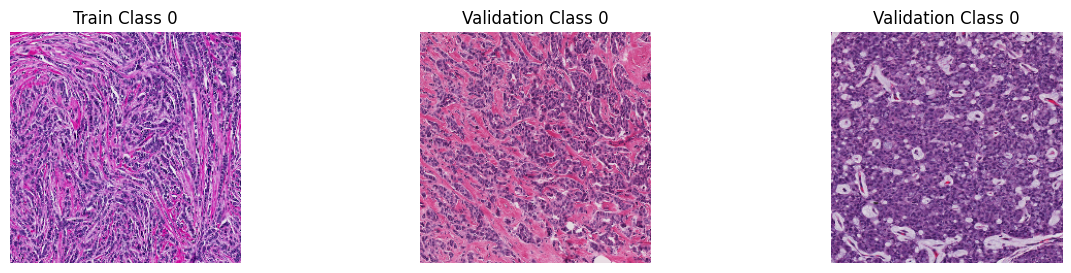

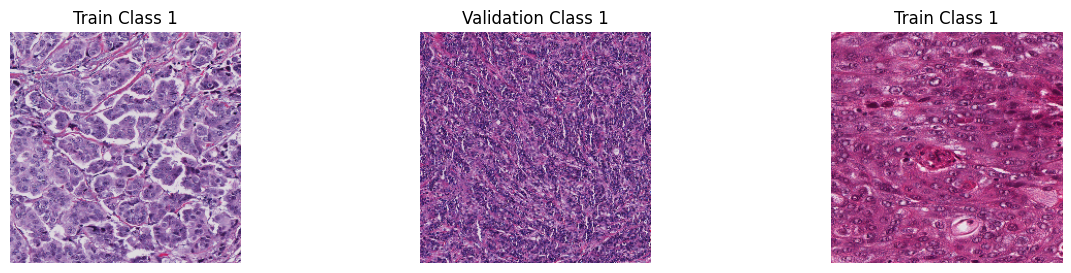

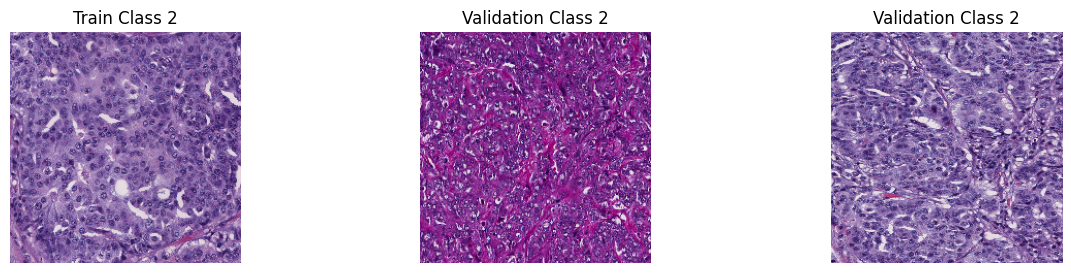

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def display_sample_images(train_images, train_labels, val_images, val_labels, num_samples_per_class=3):
    # Combine training and validation data
    images = np.concatenate((train_images, val_images), axis=0)
    labels = np.concatenate((train_labels, val_labels), axis=0)

    # Get the number of classes
    num_classes = np.max(labels) + 1

    # Initialize a list to store indices of each class
    class_indices = [[] for _ in range(num_classes)]

    # Store the indices of each class
    for i, label in enumerate(labels):
        class_indices[label].append(i)

    # Shuffle the indices of each class
    for indices in class_indices:
        np.random.shuffle(indices)

    # Display sample images for each class
    for cls in range(num_classes):
        # Get sample indices for the current class
        sample_indices = class_indices[cls][:num_samples_per_class]

        # Display sample images
        plt.figure(figsize=(15, 3))
        for i, index in enumerate(sample_indices):
            plt.subplot(1, num_samples_per_class, i+1)
            if index < len(train_images):
                plt.imshow(train_images[index])
                plt.title(f'Train Class {cls}')
            else:
                plt.imshow(val_images[index - len(train_images)])
                plt.title(f'Validation Class {cls}')
            plt.axis('off')
        plt.show()

# Example usage:
display_sample_images(trainX_fold, np.argmax(trainY_fold, axis=1), valX_fold, np.argmax(valY_fold, axis=1))


In [ ]:
pip install tensorflow

In [ ]:
# Define the labels
labels = ['Grade_1', 'Grade_2', 'Grade_3']

# Define the file path
file_path = 'labels.txt'

# Write the labels to the text file
with open(file_path, 'w') as file:
    for label in labels:
        file.write(label + '\n')

print(f'Labels saved to {file_path}')


Labels saved to labels.txt


In [ ]:
# Save the trained model in the SavedModel format
tf.saved_model.save(base_model, 'base_model_saved_model')

# Convert the SavedModel to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_saved_model('base_model_saved_model')
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open('classifier_modelhb.tflite', 'wb') as f:
    f.write(tflite_model)

print('TFLite model saved successfully.')


TFLite model saved successfully.


In [ ]:
from tensorflow.keras.models import load_model
base_model.save('/content/gdrive/MyDrive/the_new/cancer.h5')


In [ ]:
from tensorflow.keras.models import load_model
base_model.save('/content/gdrive/MyDrive/the_new/cancer.pkl')


In [ ]:
import tensorflow_hub
print(tensorflow_hub.__version__)

0.16.1
